## Imports

In [14]:
import os
import random
import gc
import imutils
import time

import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.table import Table
from reproject import reproject_interp, reproject_adaptive, reproject_exact

from astropy.coordinates import SkyCoord
from astropy import units

from tqdm import tqdm

## Load data

In [15]:
class map_object():
    def __init__(self, path, class_name, header_type = 'Herschel', prefix="", hdu_idx = 1) -> None:
        # Load the map
        self.hdu = fits.open(path, memmap=False)
        # Store data index and class name
        self.hdu_idx = hdu_idx
        self.class_name = class_name
        # Use correct header keys
        if header_type == 'Herschel':
            self.pix_scale = abs(self.hdu[self.hdu_idx].header["CD1_1"]*3600) # Pixel scale is symmetric
            print(f"Intrinsic pixel scale of map: AXIS1 = {abs(self.hdu[self.hdu_idx].header['CD1_1']*3600)}, AXIS2 = {abs(self.hdu[self.hdu_idx].header['CD2_2']*3600)}")
        else:
            self.pix_scale = abs(self.hdu[self.hdu_idx].header["CDELT1"]*3600) # Pixel scale is symmetric
            print(f"Intrinsic pixel scale of map: AXIS1 = {abs(self.hdu[self.hdu_idx].header['CDELT1']*3600)}, AXIS2 = {abs(self.hdu[self.hdu_idx].header['CDELT2']*3600)}")
        self.header_type = header_type
        
        # Grab the current directory and prepare subdirectories
        cdir = os.getcwd()
        self.fig_path = os.path.join(cdir,prefix + "PreProcessesFigs")
        self.Data_path = os.path.join(cdir,prefix + "Data")
        self.FITs_path = os.path.join(cdir,prefix + f"Data/{self.class_name}")

        # First time object creation --> create DIRS for saving
        if not os.path.isdir(self.fig_path):
            os.mkdir(self.fig_path)
        if not os.path.isdir(self.Data_path):
            os.mkdir(self.Data_path)
        if not os.path.isdir(self.FITs_path):
            os.mkdir(self.FITs_path)


    def Interpolate(self, target_pix_scale, parallel=True):
        # Copy header
        self.new_header = self.hdu[self.hdu_idx].header.copy()

        # Compute scaling
        self.target_pix_scale = target_pix_scale
        scaler = self.pix_scale/self.target_pix_scale

        # Rescale header for WCS
        self.new_header["CRPIX1"] = round(self.hdu[self.hdu_idx].header["CRPIX1"]*scaler,4)
        self.new_header["CRPIX2"] = round(self.hdu[self.hdu_idx].header["CRPIX2"]*scaler,4)
        if self.header_type == 'Herschel':
            self.new_header["CD1_1"] = float(self.hdu[self.hdu_idx].header["CD1_1"])/(scaler)
            self.new_header["CD2_2"] = float(self.hdu[self.hdu_idx].header["CD2_2"])/(scaler)
        else:
            self.new_header["CDELT1"] = float(self.hdu[self.hdu_idx].header["CDELT1"])/(scaler)
            self.new_header["CDELT2"] = float(self.hdu[self.hdu_idx].header["CDELT2"])/(scaler)
        self.new_header["NAXIS1"] = round(self.hdu[self.hdu_idx].header["NAXIS1"]*scaler)
        self.new_header["NAXIS2"] = round(self.hdu[self.hdu_idx].header["NAXIS2"]*scaler)

        # Interpolation using new header WCS, gaussian kernel
        self.interp_hdu = reproject_exact(self.hdu[self.hdu_idx], self.new_header, parallel=parallel)

        # Save coordinates of corners image to eliminate any light variation of extend of image in world coordinate.
        self.w_interp_hdu = WCS(self.new_header)
        self.w_hdu = WCS(self.hdu[self.hdu_idx].header)

        self.w_img_coords = [self.w_interp_hdu.pixel_to_world(0,0), self.w_interp_hdu.pixel_to_world(self.interp_hdu[0].shape[1]-1, 0), self.w_interp_hdu.pixel_to_world(0,self.interp_hdu[0].shape[0]-1), self.w_interp_hdu.pixel_to_world(self.interp_hdu[0].shape[1]-1, self.interp_hdu[0].shape[0]-1)]

    def plot_interp_summary(self, cmap= "gnuplot2"):
        fig = plt.figure(figsize=(10,10))
        ax1 = plt.subplot(121, projection=self.w_hdu)
        ax2 = plt.subplot(122, projection=self.w_interp_hdu)

        ax1.imshow(self.hdu[self.hdu_idx].data, origin='lower', cmap=cmap, vmin=0)
        if self.header_type == 'Herschel':
            ax1.set_title(f"Pre-interpolation {self.hdu[self.hdu_idx].header['WAVELN']} microns")
            ax2.set_title(f"Post-interpolation {self.hdu[self.hdu_idx].header['WAVELN']} microns")
        else:
            ax1.set_title(f"Pre-interpolation {self.class_name}")
            ax2.set_title(f"Post-interpolation {self.class_name}")

        ax2.imshow(self.interp_hdu[0], origin='lower', cmap=cmap, vmin=0)

        fig.savefig(f"{self.fig_path}/interp_summary_{self.class_name}.pdf")
        plt.show()
        plt.close()

    def generate_cutouts(self, center, size, idx_list = [], verbose = "real", class_type = 'input', source_df = None ,cmap = "gnuplot2"):
        # Map all NaNs to 0
        self.interp_hdu_mod = self.interp_hdu[0].copy()
        self.interp_hdu_mod[np.isnan(self.interp_hdu_mod)] = 0

        # Initiate cutout overlay plot
        fig_cutout_overlay = plt.figure(figsize=(10,10))
        ax = fig_cutout_overlay.add_subplot(111, projection=self.w_interp_hdu)
        ax.imshow(self.interp_hdu_mod.data, cmap=cmap, vmin=-np.std(self.hdu[self.hdu_idx].data))
        ax.set_title(f"Post Interpolated Image With Cutouts @ {self.class_name}")
        # if verbose == "sim":
            # img_path_diff1 = "Data/COSMOS-Nest_jk_cosmos_500_SMAP_v6.0.fits"
            # img_path_diff2 = "Data/COSMOS-Nest_jk_cosmos2_500_SMAP_v6.0.fits"
            # hdul1 = fits.open(img_path_diff1)
            # hdul2 = fits.open(img_path_diff2)
            # #hdul1.verify('fix');hdul2.verify('fix')
            # data1 = hdul1[1].data
            # data2 = hdul2[1].data
            # noise_map = data1 - data2
            # noise_map[np.isnan(noise_map)] = 0
            # noise_map = imutils.rotate(noise_map, angle=60) # Re-orient noise-map
        if len(idx_list) != 0:
            file_idx = 0
            for idx, pos in tqdm(enumerate(center), desc=f"Generating cutouts for class: {self.class_name}"):
                if idx not in idx_list:
                    continue
                cutout = Cutout2D(self.interp_hdu_mod.data, position=pos, size=size, wcs=self.w_interp_hdu, mode="strict")
                # The cutout header is only relative to the map, hence we need to create the header ourselves!
                cutout_hdr = cutout.wcs.to_header()
                center_original_pixcoord = cutout.center_original
                #print(self.w_interp_hdu.wcs_world2pix(np.array([[0,0]]), 0))
                #print(center_original_pixcoord, cutout.position_original)
                center_original_coord = self.w_interp_hdu.wcs_pix2world(np.array([list(center_original_pixcoord)]), 0)
                center_cutout_pixcoord = cutout.center_cutout
                #print(center_cutout_pixcoord, cutout.position_cutout)
                cutout_hdr['CRPIX1'], cutout_hdr['CRPIX2'] = center_cutout_pixcoord[0]+1, center_cutout_pixcoord[1]+1
                cutout_hdr['CRVAL1'], cutout_hdr['CRVAL2'] = center_original_coord[0][0], center_original_coord[0][1]
                #cutout_hdr['NAXIS1'], cutout_hdr['NAXIS2'] = size[0], size[1] 
                if verbose == "sim":
                    # noise_cutout = Cutout2D(noise_map, position=(random.randint(size[0]//2 + 1, len(noise_map[0])-(size[0]//2 + 1)), random.randint(size[1]//2 + 1, len(noise_map)-(size[1]//2 + 1))), size=size, mode="strict")
                    # while np.sum(np.array(noise_cutout.data == 0)) > size[0]*size[1] * 1/8000 and np.max(noise_cutout.data) < 0.3:
                    #     noise_cutout = Cutout2D(noise_map, position=(random.randint(size[0]//2 + 1, len(noise_map[0])-(size[0]//2 + 1)), random.randint(size[1]//2 + 1, len(noise_map)-(size[1]//2 + 1))), size=size, mode="strict")
                    # cutout.data += noise_cutout.data
                    for i in range(4):
                        # Re-set the rotation value in the header (Not present with newer conventions)

                        # cutout_hdr['CROTA1'] = i*90.
                        # cutout_hdr['CROTA2'] = i*90.
                        if self.header_type == 'Herschel':
                            cutout_hdr["CD1_1"] = self.new_header["CD1_1"]*np.cos(i*np.pi/2) - self.new_header["CD2_2"]*np.sin(i*np.pi/2)
                            cutout_hdr["CD2_2"] = self.new_header["CD1_1"]*np.sin(i*np.pi/2) + self.new_header["CD2_2"]*np.cos(i*np.pi/2)
                        else:
                            cutout_hdr["CDELT1"] = self.new_header["CDELT1"]*np.cos(i*np.pi/2) - self.new_header["CDELT2"]*np.sin(i*np.pi/2)
                            cutout_hdr["CDELT2"] = self.new_header["CDELT1"]*np.sin(i*np.pi/2) + self.new_header["CDELT2"]*np.cos(i*np.pi/2)

                        if i == 0 or i == 2:
                            cutout_hdr['CTYPE1'] = 'RA---TAN'
                            cutout_hdr['CTYPE2'] = 'DEC--TAN'
                        else:
                            cutout_hdr['CTYPE1'] = 'DEC--TAN'
                            cutout_hdr['CTYPE2'] = 'RA---TAN'
                        #print(cutout_hdr["CDELT1"],cutout_hdr["CDELT2"])
                        if class_type == 'target':
                            # The following bounding box of the cutout is only valid for box shaped cutouts
                            ra_min = pos.ra.degree - size[0]/2*self.target_pix_scale/3600
                            ra_max = pos.ra.degree + size[0]/2*self.target_pix_scale/3600
                            dec_min = pos.dec.degree - size[1]/2*self.target_pix_scale/3600
                            dec_max = pos.dec.degree + size[1]/2*self.target_pix_scale/3600
                            source_df_cutout = source_df.loc[source_df.iloc[:,0] >= ra_min]
                            source_df_cutout = source_df_cutout.loc[source_df_cutout.iloc[:,0] <= ra_max]
                            source_df_cutout = source_df_cutout.loc[source_df_cutout.iloc[:,1] >= dec_min]
                            source_df_cutout = source_df_cutout.loc[source_df_cutout.iloc[:,1] <= dec_max]
                            w_cutout = WCS(cutout_hdr)
                            #print(f"CRPIX: {cutout_hdr['CRPIX1'], cutout_hdr['CRPIX2']} // CRVAL: {cutout_hdr['CRVAL1'], cutout_hdr['CRVAL2']} // CDELT: {cutout_hdr['CDELT1'], cutout_hdr['CDELT2']}")
                            xpix = []
                            ypix = []
                            for _, source in source_df_cutout.iterrows():
                                #s_pos = SkyCoord(source['ra']*units.degree, source['dec']*units.degree, frame="fk5")
                                #Not necessayr: if cutout.wcs.footprint_contains(s_pos):
                                s_pixpos = w_cutout.wcs_world2pix(np.array([[source['ra'], source['dec']]]), 0)#w_cutout.world_to_pixel(s_pos)
                                #print(w_cutout.wcs_world2pix(np.array([[pos.ra.degree, pos.dec.degree]]), 1))

                                xpix.append(s_pixpos[0][0])
                                ypix.append(s_pixpos[0][1])
                        
                            source_df_cutout = source_df_cutout.reset_index(drop=True)
                            source_df_cutout['xpix'] = np.array(xpix, dtype=np.float32)
                            source_df_cutout['ypix'] = np.array(ypix, dtype=np.float32)

                            source_df_cutout = source_df_cutout.astype(np.float32) # To be safe
                            cols = fits.ColDefs([fits.Column(name=source_df_cutout.columns[i], format='E', array=source_df_cutout[source_df_cutout.columns[i]].to_numpy()) for i in range(len(source_df_cutout.columns))])

                            Table_hdu = fits.TableHDU.from_columns(cols)

                        primary_hdu = fits.PrimaryHDU(cutout.data.astype(np.float32), header=cutout_hdr)
                        if class_type == 'target':
                            hdul = fits.HDUList([primary_hdu, Table_hdu])
                        else:
                            hdul = fits.HDUList([primary_hdu])

                        # Store the data (and table) to the fits file
                        hdul.writeto(f"{self.FITs_path}" + f"/{self.class_name}_{file_idx}.fits", overwrite=True)

                        # Save every 5 cutouts
                        # if idx % 5 == 0 and i == 0:
                        #     fig = plt.figure(figsize=(10,10))
                        #     ax1 = plt.subplot(111, projection=WCS(cutout_hdr))
                        #     ax1.imshow(cutout.data, cmap=cmap, vmin=-np.std(cutout.data))
                        #     fig.savefig(f"{self.fig_path}" + f"/{self.class_name}_{file_idx}.pdf")
                        #     plt.close(fig)

                        if i == 0:
                            cutout.plot_on_original(color='white', ax=ax)

                        # Show the noise cutouts added to the data cutouts every 50 epochs
                        # if idx % 40 == 0 and i == 0:
                        #     fig = plt.figure(figsize=(10,10))
                        #     ax1 = plt.subplot(111, projection=WCS(cutout_hdr))
                        #     ax1.imshow(noise_cutout.data, cmap=cmap, vmin=-np.std(noise_cutout.data))
                        #     fig.savefig(f"{self.fig_path}" + f"/NoiseCutout_{self.class_name}_{file_idx}.pdf")
                        #     plt.close(fig)

                        #     # Also plot a histogram of the pixel values
                        #     histogram, bin_edges = np.histogram(cutout.data, bins=256, range=(0, 0.5))
                        #     histfig = plt.figure(figsize=(10,10))
                        #     plt.title("Grayscale Histogram")
                        #     plt.xlabel("grayscale value")
                        #     plt.ylabel("pixel count")
                        #     plt.xlim([0.0, 0.5])
                        #     plt.plot(bin_edges[0:-1], histogram)
                        #     histfig.savefig(f"{self.fig_path}" + f"/cutouthistogram_{self.class_name}_{file_idx}.pdf")
                        #     plt.close(histfig)


                        file_idx += 1

                        #cutout.data = np.rot90(cutout.data)
                        cutout.data = imutils.rotate(cutout.data, angle=90)
                else:
                    fits.writeto(f"{self.FITs_path}" + f"/{self.class_name}_{file_idx}.fits", cutout.data.astype(np.float32), cutout.wcs.to_header(), overwrite=True)

                    # Save every 5 cutouts
                    if idx % 5 == 0:
                        fig = plt.figure(figsize=(10,10))
                        ax1 = plt.subplot(111, projection=WCS(cutout.wcs.to_header()))
                        ax1.imshow(cutout.data, cmap=cmap, vmin=-np.std(cutout.data))
                        fig.savefig(f"{self.fig_path}" + f"/{self.class_name}_{file_idx}.pdf")
                        plt.close(fig)

                    if i == 0:
                        cutout.plot_on_original(color='white', ax=ax)

                    file_idx += 1            

            # Save the cutout overlay figure
            fig_cutout_overlay.savefig(f"{self.fig_path}" + f"/CutoutPlot_On_Original_{self.class_name}.pdf")
            plt.close(fig_cutout_overlay)    

        else:
            file_idx = 0
            for idx, pos in tqdm(enumerate(center), desc=f"Generating cutouts for {self.class_name} microns"):
                # Make cutout based on given center
                cutout = Cutout2D(self.interp_hdu_mod.data, position=pos, size=size, wcs=self.w_interp_hdu, mode="strict")
                # Check cutout quality: no region with zeroes and median != 0
                if np.median(cutout.data)!= 0  and np.sum(np.array(cutout.data) == 0) < size[0]*size[1] * 1/8000:
                    idx_list.append(idx) # Store good cutout idxs to be synchronized with all other classes
                    if verbose == "sim":
                        # Create a noise_cutout
                        # noise_cutout = Cutout2D(noise_map, position=(random.randint(size[0]//2 + 1, len(noise_map[0])-(size[0]//2 + 1)), random.randint(size[1]//2 + 1, len(noise_map)-(size[1]//2 + 1))), size=size, mode="strict")
                        # # Check cutout quality of noise: no region with zeroes indicating the edges of noise map
                        # while np.sum(np.array(noise_cutout.data == 0)) > size[0]*size[1] * 1/8000 and np.max(noise_cutout.data) < 0.3:
                        #     noise_cutout = Cutout2D(noise_map, position=(random.randint(size[0]//2 + 1, len(noise_map[0])-(size[0]//2 + 1)), random.randint(size[1]//2 + 1, len(noise_map)-(size[1]//2 + 1))), size=size, mode="strict")
                        # # Add the noise cutout to the data cutout
                        # cutout.data += noise_cutout.data

                        # Rotate the resulting image 4 times and save resulting image in fits format
                        ## np.float32 to reduce data strain on storage drive
                        for i in range(4):
                            # Re-set the rotation value in the header (Not present with newer conventions)
                            cutout_hdr = cutout.wcs.to_header()
                            # cutout_hdr['CROTA1'] = i*90.
                            # cutout_hdr['CROTA2'] = i*90.
                            if self.header_type == 'Herschel':
                                cutout_hdr["CD1_1"] = cutout_hdr["CD1_1"]*np.cos(i*np.pi/2) - cutout_hdr["CD2_2"]*np.sin(i*np.pi/2)
                                cutout_hdr["CD2_2"] = cutout_hdr["CD1_1"]*np.sin(i*np.pi/2) + cutout_hdr["CD2_2"]*np.cos(i*np.pi/2)
                            else:
                                cutout_hdr["CDELT1"] = cutout_hdr["CDELT1"]*np.cos(i*np.pi/2) - cutout_hdr["CDELT2"]*np.sin(i*np.pi/2)
                                cutout_hdr["CDELT2"] = cutout_hdr["CDELT1"]*np.sin(i*np.pi/2) + cutout_hdr["CDELT2"]*np.cos(i*np.pi/2)

                            if i == 0 or i == 2:
                                cutout_hdr['CTYPE1'] = 'RA---TAN'
                                cutout_hdr['CTYPE2'] = 'DEC--TAN'
                            else:
                                cutout_hdr['CTYPE1'] = 'DEC--TAN'
                                cutout_hdr['CTYPE2'] = 'RA---TAN'


                            fits.writeto(f"{self.FITs_path}" + f"/{self.class_name}_{file_idx}.fits", cutout.data.astype(np.float32), cutout_hdr, overwrite=True)
                            # Save pdf of image every 5 cutouts for checkup
                            if idx % 5 == 0 and i == 0:
                                fig = plt.figure(figsize=(10,10))
                                ax1 = plt.subplot(111, projection=WCS(cutout_hdr))
                                ax1.imshow(cutout.data, cmap=cmap, vmin=-np.std(cutout.data))
                                fig.savefig(f"{self.fig_path}" + f"/{self.class_name}_{file_idx}.pdf")
                                plt.close(fig)

                            if i == 0:
                                cutout.plot_on_original(color='white', ax=ax)

                            # Show the noise cutouts added to the data cutouts every 50 epochs
                            # if idx % 40 == 0 and i == 0:
                            #     fig = plt.figure(figsize=(10,10))
                            #     ax1 = plt.subplot(111, projection=WCS(cutout_hdr))
                            #     ax1.imshow(noise_cutout.data, cmap=cmap, vmin=-np.std(noise_cutout.data))
                            #     fig.savefig(f"{self.fig_path}" + f"/NoiseCutout_{self.class_name}_{file_idx}.pdf")
                            #     plt.close(fig)

                            #     # Also plot a histogram of the pixel values
                            #     histogram, bin_edges = np.histogram(cutout.data, bins=256, range=(0, 0.5))
                            #     histfig = plt.figure(figsize=(10,10))
                            #     plt.title("Grayscale Histogram")
                            #     plt.xlabel("grayscale value")
                            #     plt.ylabel("pixel count")
                            #     plt.xlim([0.0, 0.5])
                            #     plt.plot(bin_edges[0:-1], histogram)
                            #     histfig.savefig(f"{self.fig_path}" + f"/cutouthistogram_{self.class_name}_{file_idx}.pdf")
                            #     plt.close(histfig)

                            # For every saved image increase the count
                            ## This file_idx is synchronized with every class
                            file_idx += 1

                            # 90 degree rotation
                            cutout.data = np.rot90(cutout.data)
                            
                    # Real data evaluation
                    else:
                        fits.writeto(f"{self.FITs_path}" + f"/{self.class_name}_{file_idx}.fits", cutout.data.astype(np.float32), cutout.wcs.to_header(), overwrite=True)

                        # Save every 5 cutouts
                        if idx % 5 == 0:
                            fig = plt.figure(figsize=(10,10))
                            ax1 = plt.subplot(111, projection=WCS(cutout.wcs.to_header()))
                            plt.imshow(cutout.data, cmap=cmap, vmin=-np.std(cutout.data))
                            plt.savefig(f"{self.fig_path}" + f"/{self.class_name}_{file_idx}.pdf")
                            plt.close("all")

                        if i == 0:
                            cutout.plot_on_original(color='white', ax=ax)

                        file_idx += 1

            # Save the cutout overlay figure
            fig_cutout_overlay.savefig(f"{self.fig_path}" + f"/CutoutPlot_On_Original_{self.class_name}.pdf")
            plt.close(fig_cutout_overlay)

            return idx_list

## Comment following code if data has header
### Run only once!

## Normal code run down

0it [00:00, ?it/s]

Intrinsic pixel scale of map: AXIS1 = 6.00000000000012, AXIS2 = 6.00000000000012


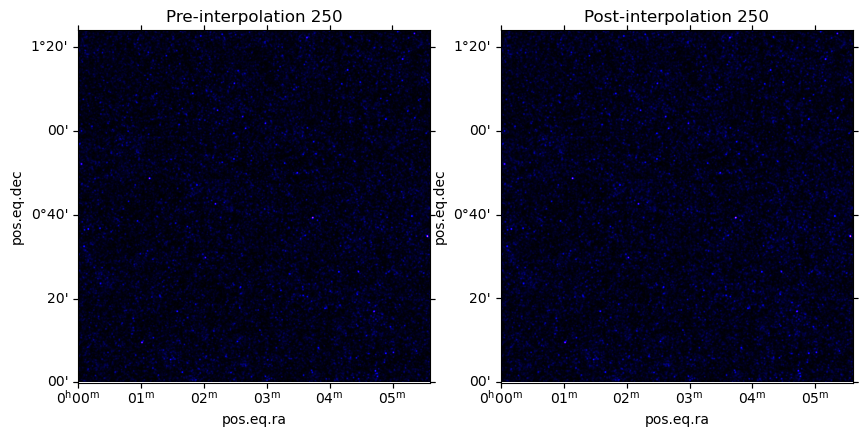

1it [00:05,  5.09s/it]

6.00000000000012
Intrinsic pixel scale of map: AXIS1 = 8.330000000000041, AXIS2 = 8.330000000000041


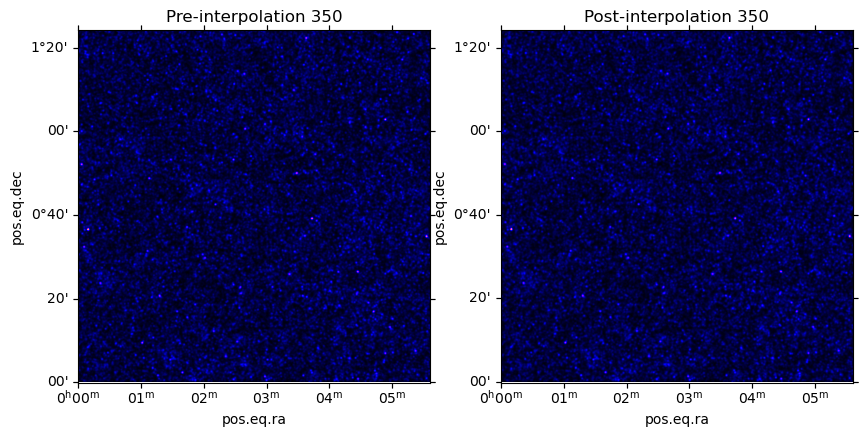

2it [00:09,  4.72s/it]

8.330000000000041
Intrinsic pixel scale of map: AXIS1 = 11.999999999999881, AXIS2 = 11.999999999999881


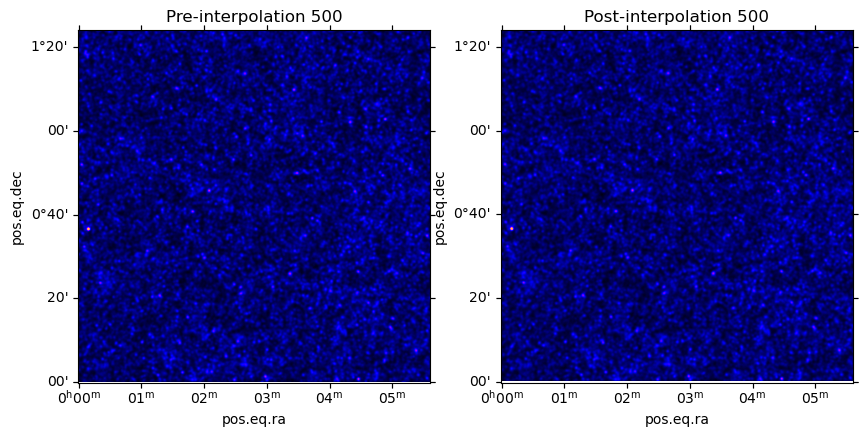

3it [00:13,  4.27s/it]

11.999999999999881
Intrinsic pixel scale of map: AXIS1 = 1.000000000000008, AXIS2 = 1.000000000000008


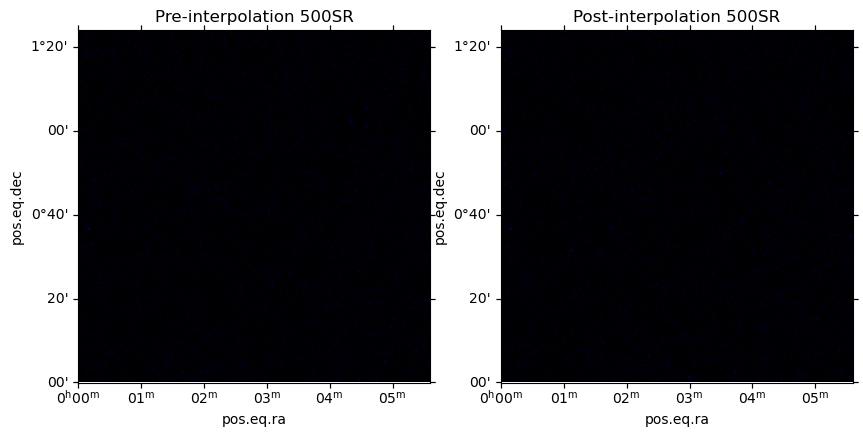

4it [02:57, 44.48s/it]

1.000000000000008


In [16]:
# PARAMS
target_pix_scale = [4, 4, 4, 1]
prefix = "sim"
paths2maps = ["Data/HerschelSim_SPIRE250_smoothed_Jy_beam.fits", "Data/HerschelSim_SPIRE350_smoothed_Jy_beam.fits", "Data/HerschelSim_SPIRE500_smoothed_Jy_beam.fits", "Data/HerschelSimSR_SPIRE500_smoothed_Jy_beam.fits"]
class_names = ["250", "350", "500", "500SR"]
inp = []
for idx, path in tqdm(enumerate(paths2maps)):
    inp.append(map_object(path, class_name = class_names[idx], header_type='pysides', prefix=prefix, hdu_idx = 0))
    if idx == len(paths2maps) - 1:
        inp[-1].Interpolate(target_pix_scale[idx], parallel = False)
    else:
        inp[-1].Interpolate(target_pix_scale[idx], parallel = True)
    inp[-1].plot_interp_summary()
    print(inp[-1].pix_scale)
    gc.collect()


In [17]:
# window_overlap = []

# for idx, inp in enumerate(input[:-1]):
#     print(f"idx={idx}, coords={inp.w_img_coords}")
#     if idx == 0:
#         window_overlap.append(inp.w_img_coords[0].ra.degree if inp.w_img_coords[0].ra.degree < inp.w_img_coords[2].ra.degree else inp.w_img_coords[2].ra.degree)
#         window_overlap.append(inp.w_img_coords[1].ra.degree if inp.w_img_coords[1].ra.degree > inp.w_img_coords[3].ra.degree else inp.w_img_coords[3].ra.degree)
#         window_overlap.append(inp.w_img_coords[0].dec.degree if inp.w_img_coords[0].dec.degree > inp.w_img_coords[1].dec.degree else inp.w_img_coords[1].dec.degree)
#         window_overlap.append(inp.w_img_coords[2].dec.degree if inp.w_img_coords[2].dec.degree < inp.w_img_coords[3].dec.degree else inp.w_img_coords[3].dec.degree)
#     else:
#         # RA left
#         if window_overlap[0] < inp.w_img_coords[0].ra.degree:
#             window_overlap[0] = inp.w_img_coords[0].ra.degree
#             if window_overlap[0] < inp.w_img_coords[2].ra.degree:
#                 window_overlap[0] = inp.w_img_coords[2].ra.degree
#         # RA Right
#         if window_overlap[1] > inp.w_img_coords[1].ra.degree:
#             window_overlap[1] = inp.w_img_coords[1].ra.degree
#             if window_overlap[1] > inp.w_img_coords[3].ra.degree:
#                 window_overlap[1] = inp.w_img_coords[3].ra.degree

#         # DEC Bottom
#         if window_overlap[2] > inp.w_img_coords[0].dec.degree:
#             window_overlap[2] = inp.w_img_coords[0].dec.degree
#             if window_overlap[2] > inp.w_img_coords[1].dec.degree:
#                 window_overlap[2] = inp.w_img_coords[1].dec.degree

#         # DEC Top
#         if window_overlap[3] < inp.w_img_coords[2].dec.degree:
#             window_overlap[3] = inp.w_img_coords[2].dec.degree
#             if window_overlap[3] > inp.w_img_coords[3].dec.degree:
#                 window_overlap[3] = inp.w_img_coords[3].dec.degree

SIZE = (106,106)
# ((SIZE[1] * target_pix_scale)//2 - 100)/3600
xpos = np.linspace(0 + ((SIZE[1] * target_pix_scale[0])//2 + 50)/3600, 1.4 - ((SIZE[1] * target_pix_scale[0])//2 + 50)/3600, 14)
ypos = np.linspace(0 + ((SIZE[0] * target_pix_scale[0])//2 + 50)/3600, 1.4 - ((SIZE[0] * target_pix_scale[0])//2 + 50)/3600, 14)
center = [SkyCoord(y*units.degree, x*units.degree, frame="fk5") for x in xpos for y in ypos]
print(center[0], (SIZE[1] * target_pix_scale[0])/3600)


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (0.07277778, 0.07277778)> 0.11777777777777777


In [18]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
SIZE_LIST = [(106,106), (106,106), (106,106), (424,424)]
with fits.open("Data/Herschel250_350_500_sim.fits", memmap=False) as hdu:
    source_df = pd.DataFrame(hdu[1].data).iloc[:, [1, 2, 14]]
    source_df = source_df.loc[source_df.iloc[:,-1] >= 1/1000]
source_df = source_df.reset_index(drop=True)
for idx, map_obj in enumerate(inp):
    if idx == 0:
        idx_list = map_obj.generate_cutouts(center, SIZE_LIST[idx], idx_list=[], verbose = prefix)
        print("Cutouts: ", len(idx_list))
    elif idx == len(inp) - 1:
        map_obj.generate_cutouts(center, SIZE_LIST[idx], idx_list=idx_list, verbose = prefix, class_type='target', source_df=source_df)
    else:
        map_obj.generate_cutouts(center, SIZE_LIST[idx], idx_list=idx_list, verbose = prefix)
    gc.collect()

Generating cutouts for 250 microns: 196it [00:21,  9.32it/s]


Cutouts:  196


Generating cutouts for class: 350: 196it [00:03, 57.06it/s]
Generating cutouts for class: 500: 196it [00:03, 64.09it/s]
Generating cutouts for class: 500SR: 196it [00:25,  7.57it/s]


In [19]:
import gc
gc.collect()

136112

In [20]:
def t():
    return 2, 5

x = [t() for i in range(3)]

In [21]:
len(x)

3